<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Software-Agents-Notebook-Q-learning-script-for-Auction-bot-that-optimally-purchases-an-item-at-a-maximum-value-during-an-auction." data-toc-modified-id="Software-Agents-Notebook-Q-learning-script-for-Auction-bot-that-optimally-purchases-an-item-at-a-maximum-value-during-an-auction.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Software Agents Notebook Q-learning script for Auction bot that optimally purchases an item at a maximum value during an auction.</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Analysis-function-below-for-performance" data-toc-modified-id="Analysis-function-below-for-performance-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Analysis function below for performance</a></span><ul class="toc-item"><li><span><a href="#Training-and-testing-block-for-learning-decay-occuring-only-at-random-action-only-step-." data-toc-modified-id="Training-and-testing-block-for-learning-decay-occuring-only-at-random-action-only-step-.-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Training and testing block for learning decay occuring only at random action only step .</a></span></li><li><span><a href="#Visualisation-block-for-graphing-results.-basic-Matplotlib-here." data-toc-modified-id="Visualisation-block-for-graphing-results.-basic-Matplotlib-here.-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Visualisation block for graphing results. basic Matplotlib here.</a></span></li></ul></li><li><span><a href="#Trial-Agent-where-constant-epsilon-decay-on-every-step." data-toc-modified-id="Trial-Agent-where-constant-epsilon-decay-on-every-step.-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Trial Agent where constant epsilon decay on every step.</a></span><ul class="toc-item"><li><span><a href="#Reinitialise-trial-agent-episilon" data-toc-modified-id="Reinitialise-trial-agent-episilon-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Reinitialise trial agent episilon</a></span></li><li><span><a href="#Training-and-testing-block-for-learning-decay-occuring-only-at-random-action-only-step-." data-toc-modified-id="Training-and-testing-block-for-learning-decay-occuring-only-at-random-action-only-step-.-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Training and testing block for learning decay occuring only at random action only step .</a></span></li><li><span><a href="#Visualisation-block-for-graphing-results.-basic-Matplotlib-here." data-toc-modified-id="Visualisation-block-for-graphing-results.-basic-Matplotlib-here.-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Visualisation block for graphing results. basic Matplotlib here.</a></span></li></ul></li></ul></li></ul></div>

# Software Agents Notebook Q-learning script for Auction bot that optimally purchases an item at a maximum value during an auction. 

## Introduction 

The purpose of this jupyter notebook is to outline how to initialise and appropriately train a software agent to bid appropriately for an item during an auction. 

In [14]:
#Import libraries required for training 

import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
import random
import glob
import re
#Look at importing pyspark to make it go faster? 

In [15]:
#Initialisation step define epsilon, alpha, gamma and value of agent. 
class Auction_Agent():
    
    import pandas as pd
    
    def __init__(self,duration_timesteps=0,epsilon=0,exploration_policy_decay=0,exploration_policy_decay_2=0,\
                 exploration_policy_decay_3=0,alpha=0,gamma=0,agent_value=0,max_bidding_price=0,\
                 No_States=0,No_Actions=0):
                  
        
        self.duration_timesteps=duration_timesteps
        self.epsilon=epsilon
        self.exploratory_decay=exploration_policy_decay
        self.exploratory_decay_2=exploration_policy_decay_2
        self.exploratory_decay_3=exploration_policy_decay_3
        self.alpha=alpha
        self.gamma=gamma
        self.agent_value=agent_value
        self.Max_bidding_price=max_bidding_price
        self.No_States=int(self.Max_bidding_price+2) #Additional States added on for nan and exit states
        self.No_Actions=int(self.Max_bidding_price+2)
        self.zero_df=Auction_Agent.zero_df(self) 
               
    @classmethod
    def from_input(cls):
        return cls(
            int(input('No of Duration timesteps: ')), #Number of time steps in action. 
            float(input('Exploration policy, epsilon: ')),  # Rate at which exploratory learning occurs 
            float(input('Exploration stopping policy decay, eps_decay: ')),  # Rate at which exploratory learning decays and exploitation policy takes over
            float(input('Secondary decay factor eps_decay_2: ')),
            float(input('Secondary decay factor eps_decay_3: ')),
            float(input('Learning rate, alpha: ')), #Learning rate update for Q matrix 
            float(input('Discount factor Parameter,gamma: ')), #Discount factor effect of future moves on decision matrix. 
            float(input('Agent auction value: ')), #Value of agent 
            float(input('Max bidding price: ')))
    
    @staticmethod #Static method to create attribute to be used in creating R and Q matrix methods 
    def zero_df(self): #self denotes that self attributes can be utilised here. 
        
        #Create dictionary to then be transformed into a dataframe which will be tranformed into a panel for 3-D reward matrix. 
        #Panel dictoinary will collect copies of final_dict and create a 3_d reward matrix. 

        final_dict={}
        
        zero_count=1 #initialising the size of zero list this will increase with time. 
        None_count=int(self.No_States-zero_count) #initialising the size of None list this will decrease with time.
        cols=1

        while cols < self.No_Actions: #While loop iteratethrough and creates dictionary to be used as T matrix.
            key=cols

            zero_list=[0]*zero_count #Create0 values for each column in dataframe
            none_list=[None]*None_count #Create NaN values for each column in dataframe

            final_list=zero_list+none_list #Combine values together to create column for keyvalue col

            zero_count+=1 #Iterate zero count and None count up and down respectivety in order to ensure diagonal matrix is 
            None_count-=1 #achieved

            if len(zero_list)==1: #Specific renaming of initial column as we start in NaN state to begin with in auction 
                final_dict['Nan']=final_list
            else:
                final_dict[cols-1]= final_list #Providing 

            cols+=1 #Increase column size up to total number of actions

        final_dict['Exit']=[0]*int(self.No_Actions)#Adding final reward matrix where 

        zero_df=pd.DataFrame.from_dict(final_dict) #Generates dataframe from dictionary
        zero_df.index=zero_df.columns #Convert dataframe index to be the same as columns for Nan and exit values
        
        return zero_df
        
    @property
    def R_matrix(self):
        #Creating final reward dataframe to iterate through next and add reward values 
        panel_dict={} 
        reward_df=self.zero_df.copy() #Copy used to stop dataframe acquiring new object name 

        R_mat_cols=list(reward_df.columns) #
        for cols in R_mat_cols: #removing all non number values 

            if isinstance(cols, str)==True:
                R_mat_cols.remove(cols)

        for vals in R_mat_cols: #Removing all zero values with reward values based on initial valuation set by user. 

            temp=reward_df[vals]
            reward_value=self.agent_value-vals
            temp.replace(0.0,reward_value,inplace=True)
            reward_df[vals]=temp

        for i in range(self.duration_timesteps): #Creating duplicated of zero matrices based on number of timesteps set by user
            panel_dict[i]=self.zero_df

        #print(panel_dict)
        panel_dict[self.duration_timesteps]=reward_df
        #print(panel_dict)
        return pd.Panel(panel_dict)
            
    
    @property #At property turns method 
    def Q_matrix(self): #self denotes that self attributes can be utilised here. 
        panel_dict={} 
        #Creating final reward dataframe to iterate through next and add reward values 
        
        for i in range(self.duration_timesteps+1): #Creating duplicated of zero matrices based on number of timesteps set by user
            panel_dict[i]=self.zero_df

        #print(panel_dict)
        return pd.Panel(panel_dict)
    


In [16]:
def exploration_exploitation_rand_act_decay_policy(Trial_agent,count_rand,count_arg_max):
    
   #Iterating through policy where random exploration or arg max exploitation decision is made"""
    
    if random.uniform(0, 1) < Trial_agent.epsilon:
        
        #Counting number of random actions taken per episode
        count_rand+=1
        #Select No states randomly for agent. 
        Action_index=random.randint(state_index, Trial_agent.No_States-1)
        #print(f'Random Action taken at time {t} for state {state_index} is {Action_index}')

        #Decay of exploration exploration policy based exploratory decay 
        if Trial_agent.epsilon>Trial_agent.exploratory_decay:
            Trial_agent.epsilon=Trial_agent.epsilon*Trial_agent.exploratory_decay_2
        else:
            Trial_agent.epsilon=Trial_agent.epsilon*Trial_agent.exploratory_decay_3

    #Iterating through argmax policy if random policy not selected.       
    else:
        #Counting number of arg max actions taken per episode
        count_arg_max+=1
    
        temp=Qmatrix[t].iloc[state_index,state_index:]
        
        count_neg_vals=temp[temp<0].count()
        count_greater_zero=temp[temp>0].count()
        No_data_points=temp.count()
        Zero_max=No_data_points-count_neg_vals
        
        if count_greater_zero==0 and Zero_max==1:
            #print(Qmatrix[t].iloc[state_index,state_index:])
            Action_index=random.randint(state_index, Trial_agent.No_States-1)
            #print(f'Rand Argmax Action taken at time {t} for state {state_index} is {Action_index}')
        else:
            Non_num_index = Qmatrix[t].iloc[state_index,state_index:].idxmax() # Exploit learned values
            #print(Qmatrix[t].iloc[state_index,state_index:])
            Action_index=Columns.index(Non_num_index)
            #print(f'Non Rand Argmax Action taken at time {t} for state {state_index} is {Action_index}')
    
    
    
    return Action_index,count_rand,count_arg_max

In [17]:
def exploration_exploitation_constant_decay_policy(Trial_agent,count_rand,count_arg_max):
    
   #Iterating through policy where random exploration or arg max exploitation decision is made"""
    
    if random.uniform(0, 1) < Trial_agent.epsilon:
        
        #Counting number of random actions taken per episode
        count_rand+=1
        #Select No states randomly for agent. 
        Action_index=random.randint(state_index, Trial_agent.No_States-1)
        #print(f'Random Action taken at time {t} for state {state_index} is {Action_index}')

    #Iterating through argmax policy if random policy not selected.       
    else:
        #Counting number of arg max actions taken per episode
        count_arg_max+=1

        Non_num_index = Qmatrix[t].iloc[state_index,state_index:].idxmax() # Exploit learned values

        Action_index=Columns.index(Non_num_index)
        #print(f'Argmax Action taken at time {t} for state {state_index} is {Action_index}')
        
        #Decay of exploration exploration policy based exploratory decay 
    if Trial_agent.epsilon>Trial_agent.exploratory_decay:
        Trial_agent.epsilon=Trial_agent.epsilon*Trial_agent.exploratory_decay_2
    else:
        Trial_agent.epsilon=Trial_agent.epsilon*Trial_agent.exploratory_decay_3
    
    
    return Action_index,count_rand,count_arg_max

In [18]:
def Generate_Q_update_values(Rmatrix,Qmatrix,Trial_agent,state_index,Action_index):
    
    #Purpose of function to create new Q matrix value to update as per Bellman's equation. 

    Reward = Rmatrix[t].iloc[state_index,Action_index] # Determine reward from taken action 
    #print(f'Reward value is {Reward}')
    #Creating parameters for iterating through for updating q matrix for analysis 
    #Acquire old q matrix value
    Q_old=Qmatrix[t].iloc[state_index,Action_index]
    #print(f'Q_old value is {Q_old}')

    #Determine q matrix t+1 upper value provided not at t end point and agent has not selected exit action 
    if t<Trial_agent.duration_timesteps and Action_index!=Trial_agent.No_States-1:

        Q_future_index=Qmatrix[t+1].iloc[Action_index,Action_index:Trial_agent.No_States-1].idxmax()
        Q_future_index=Columns.index(Q_future_index)
        Q_future_value=Qmatrix[t+1].iloc[Action_index,Q_future_index]
        #print(f'Q_future_value is {Q_future_value}')

    else:
        Q_future_value=0

    #Calculate Q update value
    Q_update=Q_old+Trial_agent.alpha*(Reward \
                                     +Trial_agent.gamma*Q_future_value
                                     -Q_old)
    
    
    return (Q_update, Reward)

In [19]:
def Q_Matrix_converge_chk(Q_matrix_chk,
                          Q_matrix_temp,
                          Converge_count,
                          Converge_threshold,
                          Converge_breaker):
    """Purpose of this method is to check if Q matrix has converged. 
    This is determined my confirming that Q matrix has remained static for more than the convergence threshold"""

    
    if Q_matrix_chk.equals(Q_matrix_temp)==True: #If old Qmatrix equals new Q matrix update convergence count by 1 
        Converge_count+=1
    else: #If old Qmatrix does not equal new Q matrix reduce convergence count to 0 
        Converge_count=0
        
    if Converge_count==Converge_threshold:
        Converge_breaker=True
    else:
        Converge_breaker=False
    #print(f'method converge count is: ',Converge_count)
    #print(f'method converge breaker is: ',Converge_breaker)
    return Converge_count,Converge_breaker

## Analysis function below for performance

1. run Trial_agent below and input in duration of time steps episilon etc
2. Run Training and testing block. 
3. Run visualisation charts block to observe performance. 
4. If you want to re run the training and testing block you will need to reinitialise the trial agent episilon as it decays to 0 during training and testing analysis. 

In [11]:
Trial_agent=Auction_Agent.from_input()


No of Duration timesteps: 5
Exploration policy, epsilon: 1
Exploration stopping policy decay, eps_decay: 0.2
Secondary decay factor eps_decay_2: 0.999
Secondary decay factor eps_decay_3: 0.9
Learning rate, alpha: 0.9
Discount factor Parameter,gamma: 0.9
Agent auction value: 3
Max bidding price: 5


In [7]:
import os
os.chdir(r'C:\Users\niall\OneDrive\Documents\Data science masters\Software agents\10000 runs epsilon check')

In [13]:
Rmatrix=Trial_agent.R_matrix
Rmatrix[5]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  """Entry point for launching an IPython kernel.


Nan    1    2    3    4    5  Exit
Nan   0.0  2.0  1.0  0.0 -1.0 -2.0   0.0
1     NaN  2.0  1.0  0.0 -1.0 -2.0   0.0
2     NaN  NaN  1.0  0.0 -1.0 -2.0   0.0
3     NaN  NaN  NaN  0.0 -1.0 -2.0   0.0
4     NaN  NaN  NaN  NaN -1.0 -2.0   0.0
5     NaN  NaN  NaN  NaN  NaN -2.0   0.0
Exit  NaN  NaN  NaN  NaN  NaN  NaN   0.0

In [ ]:
Trial_agent.epsilon = 0.95
Trial_agent.exploratory_decay_2=0.9999
No_epochs_pt1=(Trial_agent.epsilon-Trial_agent.exploratory_decay)

No_epochs_pt2=(Trial_agent.epsilon\
               -Trial_agent.epsilon*Trial_agent.exploratory_decay_2)

No_epochs_pt3=No_epochs_pt2/Trial_agent.epsilon


No_epochs_pt4=int(No_epochs_pt1/No_epochs_pt3)
No_epochs=No_epochs_pt4+0.4*No_epochs_pt4
No_epochs

### Training and testing block for learning decay occuring only at random action only step . 

Grid Search on varying alpha and gamma values.

In [22]:
#Grid Search on varying alpha and gamma values.

#------------------------GRID--SEARCH------------------------------------
avg_final_r = []
epsilon_values_1 = []
epsilon_values_2 = []
convpoints = []

#grid search parameters
Eps_decay_1= [0.9,0.99, 0.999, 0.9999] # 
Eps_decay_2 = [0.01,0.9,0.99, 0.999, 0.9999] #

#os.chdir(r'\\nsq024vs\u8\aczd087\MyDocs\Data science masters\Software Agents\Coursework\Results\Epsilon Trials')

for eps1 in Eps_decay_1:
    
    for eps2 in Eps_decay_2:
        
        #manually define variables
        #Trial_agent.duration_timesteps = 5
        Trial_agent.epsilon = 1
        Trial_agent.exploratory_decay_2=eps1
        Trial_agent.exploratory_decay_3 = eps2
        Trial_agent.alpha = 0.9
        Trial_agent.gamma = 0.9
        #Trial_agent.agent_value = 6
        #Trial_agent.Max_bidding_price = 9
        
        #Convergence parameters
        converge_breaker=False
        Converge_count=0
        Conv_threshold=90
        
        filename='eps1_'+str(eps1)+'eps2_'+str(eps2)+'_Qlearn.xlsx'
        conv_threshold_list=[]
        conv_count_list=[]
        Q_matrix_match=[]
        Q_sum_trend=[]
        Q_sum_abs_trend=[]
        Q_var_trend=[]
        Q_mean_trend=[]
        # testing and training block. 
        epoch_time = []
        epoch_reward = []
        epoch_no=[]
        exploration_decay=[]
        No_Explore_act=[]
        No_Exploit_act=[]
        Q_matrix_values=[]
        #Determine threshold to switch from exploration to exploitation
        No_epochs_pt1=(Trial_agent.epsilon-Trial_agent.exploratory_decay)
        #print(No_epoch_pt1)
        No_epochs_pt2=(Trial_agent.epsilon\
                       -Trial_agent.epsilon*Trial_agent.exploratory_decay_2)
        #print(No_epochs_pt2)
        No_epochs_pt3=No_epochs_pt2/Trial_agent.epsilon
        #print(No_epochs_pt3)
        No_epochs_pt4=int(No_epochs_pt1/No_epochs_pt3)
        No_epochs=int(No_epochs_pt4+0.4*No_epochs_pt4)
        print(f'No of epochs: {No_epochs}')

        # Number of epcohs performed for training and testing analysis. Increase as necessary., 
        #Initialising blank R and Q matrices for training 

        Qmatrix=Trial_agent.Q_matrix
        Rmatrix=Trial_agent.R_matrix
        print('Qmatrix sum: ', Qmatrix.sum().sum().sum())

        #import ipdb
        #ipdb.sset_trace()

        #Iterate through each Epoch
        for i in range(1,No_epochs):
            #print(i)
            
            #Old Q matrix for comparison in convergence
            Qmatrix_old=Qmatrix.copy()
            Qmatrix_old_pt2=Qmatrix_old.values
            #print('converge count in for loop pre method is',Converge_count)

            t=0 #Initialising time point for auction
            count_rand=0
            count_arg_max=0
            #Iterate through each time poin tin the 
            while t <= Trial_agent.duration_timesteps:
                #print(t)

                if t==0: #Initialising state for initial time step. 
                    state_index=0

                #Initialising q matrix columns index 
                Columns=list(Qmatrix[t].columns)

                [Action_index, count_rand, count_arg_max]=exploration_exploitation_rand_act_decay_policy(Trial_agent,count_rand,count_arg_max)

                (Q_update,Reward)=Generate_Q_update_values(Rmatrix,Qmatrix,Trial_agent,state_index,Action_index)    

                #print(f'Q_update value is {Q_update}')

                Qmatrix[t].iloc[state_index,Action_index]=Q_update

                #Update for state index and move on to the next 

                #If Exit action is selected break whileloop and end training. 
                if state_index ==Trial_agent.No_States-1:
                    #print(f'Break action taken')
                    #Other actions to be written here 
                    break

                state_index=Action_index
                #print(f'New state index is {state_index}')
                
                t+=1 #Time point increases as each step in the auction improves

            #Final results information. 
            epoch_time.append(t)
            epoch_reward.append(Reward)
            exploration_decay.append(Trial_agent.epsilon)
            epoch_no.append(i)
            No_Explore_act.append(count_rand)
            No_Exploit_act.append(count_arg_max)
            
            #print('Q matrix old equal to new Q matrix:',Qmatrix_old.equals(Qmatrix))
                    #Convergence parameters
            #Check convergence between old Q matrix and updated one. 
            (Converge_count,converge_breaker)=Q_Matrix_converge_chk(Qmatrix_old,\
                                                           Qmatrix,\
                                                           Converge_count,\
                                                           Conv_threshold,\
                                                          converge_breaker)
            
            conv_count_list.append(Converge_count)
            conv_threshold_list.append(converge_breaker)
            temp=Qmatrix.values
            temp2=Qmatrix.fillna(value=0)
            Q_matrix_match.append(np.array_equal(Qmatrix_old_pt2[~np.isnan(Qmatrix_old_pt2)], temp[~np.isnan(temp)]))
            Q_sum_abs_trend.append(Qmatrix.abs().sum().sum().sum())
            Q_sum_trend.append(Qmatrix.sum().sum().sum())
            Q_var_trend.append(temp2.var().var().var())
            Q_mean_trend.append(temp2.mean().mean().mean())
            

        results_df=pd.DataFrame(data={'Epoch_Number':epoch_no,\
                                      'No_time_steps':epoch_time,\
                                      'Final_reward':epoch_reward,\
                                      'Exploration_decay':exploration_decay,\
                                     'No_Explore_act':No_Explore_act,\
                                     'No_Exploit_act':No_Exploit_act,\
                                      'Convergence count': conv_count_list,\
                                     'convergence Achieve': conv_threshold_list,\
                                     'Q_matrix_match':Q_matrix_match,\
                                     'Q_abs_sum_trend':Q_sum_abs_trend,\
                                     'Q_sum_trend':Q_sum_trend,\
                                     'Q_var_trend':Q_var_trend,\
                                     'Q_mean_trend':Q_mean_trend})
        results_df['Rewards_moving_average_30']=results_df['Final_reward'].rolling(window=30,center=False).mean()
        results_df['No_steps_taken_moving_average']=results_df['No_time_steps'].rolling(window=20,center=False).mean()
        results_df['No_Explore_act_moving_average']=results_df['No_Explore_act'].rolling(window=20,center=False).mean()
        results_df['No_Exploit_act_moving_average']=results_df['No_Exploit_act'].rolling(window=20,center=False).mean()
            
            
        #Convergence point   
        #find convergence point (point with most significant negative parcentage change)
        
        #Save_results_to_excel_file
        results_df.to_excel(filename)
        
        convpoint = results_df[results_df['Rewards_moving_average_30'].pct_change() < -0.2].Epoch_Number.min()
        
        #Average final reward
        #isolate final 100 epochs 
        results_f100 = results_df.iloc[-100:, :]
        #avgerage the reward of final 100 epochs
        avg_final_reward = results_f100['Final_reward'].mean()
        
        #print prompts for checks/processing status
        print('Epsilon value 1: ',eps1)
        print('Epsilon value 2: ',eps2) 
        print('Final_epsilon_value:',Trial_agent.epsilon)
        print("Avg final reward: ", avg_final_reward)
        print("Convergence Point: ", convpoint)
        
        
        #append grid search results into respective lists
        avg_final_r.append(avg_final_reward)
        epsilon_values_1.append(eps1)
        epsilon_values_2.append(eps2)
        convpoints.append(convpoint)

#compile grid search results lists into dataframe
grid_df=pd.DataFrame(data={'Epsilon value 1':eps1,\
                           'Epsilon value 2':eps2,\
                           'Avg_Final_reward':avg_final_r,\
                           'Convergence Epoch':convpoints})


No of epochs: 11
Qmatrix sum:  0.0


c:\users\niall\anaconda3\lib\site-packages\ipykernel_launcher.py:64: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

c:\users\niall\anaconda3\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

c:\users\niall\anaconda3\lib\site-packages\ipykernel_launcher.py:76: DeprecationWarning: 
Panel is deprecate

Epsilon value 1:  0.9
Epsilon value 2:  0.01
Final_epsilon_value: 0.0018530201888518419
Avg final reward:  0.3
Convergence Point:  nan
No of epochs: 11
Qmatrix sum:  0.0
Epsilon value 1:  0.9
Epsilon value 2:  0.9
Final_epsilon_value: 0.0984770902183612
Avg final reward:  -0.1
Convergence Point:  nan
No of epochs: 11
Qmatrix sum:  0.0
Epsilon value 1:  0.9
Epsilon value 2:  0.99
Final_epsilon_value: 0.18344899869633235
Avg final reward:  -0.1
Convergence Point:  nan
No of epochs: 11
Qmatrix sum:  0.0
Epsilon value 1:  0.9
Epsilon value 2:  0.999
Final_epsilon_value: 0.18456192188073398
Avg final reward:  -1.1
Convergence Point:  nan
No of epochs: 11
Qmatrix sum:  0.0
Epsilon value 1:  0.9
Epsilon value 2:  0.9999
Final_epsilon_value: 0.1851353137613513
Avg final reward:  -0.1
Convergence Point:  nan
No of epochs: 110
Qmatrix sum:  0.0
Epsilon value 1:  0.99
Epsilon value 2:  0.01
Final_epsilon_value: 0.0019827425658891446
Avg final reward:  0.24
Convergence Point:  32
No of epochs: 110

In [24]:
os.chdir(r'C:\Users\niall\OneDrive\Documents\Data science masters\Software agents\10000 runs epsilon check')

files=os.listdir()


In [25]:
files

['eps1_0.9999eps2_0.01_Qlearn.xlsx',
 'eps1_0.9999eps2_0.9999_Qlearn.xlsx',
 'eps1_0.9999eps2_0.999_Qlearn.xlsx',
 'eps1_0.9999eps2_0.99_Qlearn.xlsx',
 'eps1_0.9999eps2_0.9_Qlearn.xlsx',
 'eps1_0.999eps2_0.01_Qlearn.xlsx',
 'eps1_0.999eps2_0.9999_Qlearn.xlsx',
 'eps1_0.999eps2_0.999_Qlearn.xlsx',
 'eps1_0.999eps2_0.99_Qlearn.xlsx',
 'eps1_0.999eps2_0.9_Qlearn.xlsx',
 'eps1_0.99eps2_0.01_Qlearn.xlsx',
 'eps1_0.99eps2_0.9999_Qlearn.xlsx',
 'eps1_0.99eps2_0.999_Qlearn.xlsx',
 'eps1_0.99eps2_0.99_Qlearn.xlsx',
 'eps1_0.99eps2_0.9_Qlearn.xlsx',
 'eps1_0.9eps2_0.01_Qlearn.xlsx',
 'eps1_0.9eps2_0.9999_Qlearn.xlsx',
 'eps1_0.9eps2_0.999_Qlearn.xlsx',
 'eps1_0.9eps2_0.99_Qlearn.xlsx',
 'eps1_0.9eps2_0.9_Qlearn.xlsx']

In [27]:
#Analyse and assess the files run results. 

Final_results=pd.DataFrame(columns=['Decay_Factor1','Decay_Factor2','Converg_count','Avg_100Final_reward'])

for f in files:
    print(f)
    data = pd.read_excel(f)
    listr=re.findall(r"[-+]?\d*\.\d+|\d+", f)
    print(listr)
    temp_eps1=listr[1]
    temp_eps2=listr[3]
    Converged_idx=0
    Final_reward=0
    
    for idx,vals in data['Q_abs_sum_trend'].iteritems():
        
        size=data.shape
        
        if size[0]<200:
            Final_reward=data['Final_reward'].mean()
            Converged_idx=size[0]
        else:
            Final_reward=data['Final_reward'][-100:].mean()
            
            Final_chk=float((data['Q_abs_sum_trend'][-1:]-vals)/data['Q_abs_sum_trend'][-1:])
            #print(Final_chk)
           
            if Final_chk<0.03:
                Converged_idx=idx
                print('End of file: ',f)
                break
    
    Final_results.loc[len(Final_results)] = [temp_eps1,temp_eps2,Converged_idx,Final_reward]


eps1_0.9999eps2_0.01_Qlearn.xlsx
['1', '0.9999', '2', '0.01']
End of file:  eps1_0.9999eps2_0.01_Qlearn.xlsx
eps1_0.9999eps2_0.9999_Qlearn.xlsx
['1', '0.9999', '2', '0.9999']
End of file:  eps1_0.9999eps2_0.9999_Qlearn.xlsx
eps1_0.9999eps2_0.999_Qlearn.xlsx
['1', '0.9999', '2', '0.999']
End of file:  eps1_0.9999eps2_0.999_Qlearn.xlsx
eps1_0.9999eps2_0.99_Qlearn.xlsx
['1', '0.9999', '2', '0.99']
End of file:  eps1_0.9999eps2_0.99_Qlearn.xlsx
eps1_0.9999eps2_0.9_Qlearn.xlsx
['1', '0.9999', '2', '0.9']
End of file:  eps1_0.9999eps2_0.9_Qlearn.xlsx
eps1_0.999eps2_0.01_Qlearn.xlsx
['1', '0.999', '2', '0.01']
End of file:  eps1_0.999eps2_0.01_Qlearn.xlsx
eps1_0.999eps2_0.9999_Qlearn.xlsx
['1', '0.999', '2', '0.9999']
End of file:  eps1_0.999eps2_0.9999_Qlearn.xlsx
eps1_0.999eps2_0.999_Qlearn.xlsx
['1', '0.999', '2', '0.999']
End of file:  eps1_0.999eps2_0.999_Qlearn.xlsx
eps1_0.999eps2_0.99_Qlearn.xlsx
['1', '0.999', '2', '0.99']
End of file:  eps1_0.999eps2_0.99_Qlearn.xlsx
eps1_0.999eps2_0

In [32]:
Final_results.to_excel('QlearningDECAYfACTORSummary_results.xlsx')

In [35]:
Final_results.Converg_count

0     5733
1     2868
2     7103
3     5678
4     6864
5      548
6      729
7      501
8      502
9      371
10     109
11     109
12     109
13     109
14     109
15      10
16      10
17      10
18      10
19      10
Name: Converg_count, dtype: object

In [36]:
#Convert Converge count to float type 

Final_results["Converg_count"]= Final_results["Converg_count"].astype(float)
#Final_results.columns=['Epsilon 1', 'Epsilon Decay', 'Converg_count', 'Avg_100Final_reward']

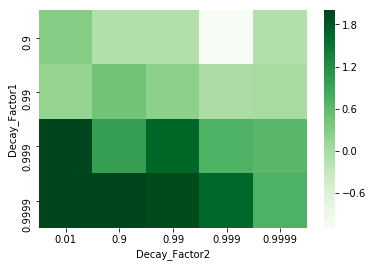

In [30]:

grid_df_2 = Final_results.pivot('Decay_Factor1', 'Decay_Factor2', "Avg_100Final_reward")
fig=sns.heatmap(grid_df_2, cmap="Greens")
sns_plot = fig.get_figure()
sns_plot.savefig("Episilon_Epsilon1_Epsilon2_avg_reward.jpeg")

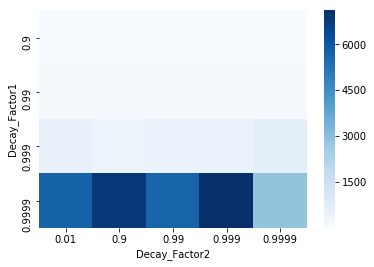

In [37]:
grid_df_3 = Final_results.pivot('Decay_Factor1', 'Decay_Factor2', "Converg_count")
fig=sns.heatmap(grid_df_3, cmap="Blues")
sns_plot = fig.get_figure()
sns_plot.savefig("Epsilon_Epsilon1_Epsilon2_convg_count.jpeg")

In [ ]:
#results_df.set_index(epoch_no,inplace=True)
results_df.plot(subplots=True,figsize=(20, 15))
plt.legend(loc='best')

In [ ]:
results_df.plot(data

In [ ]:
Qmatrix.abs().sum().sum().sum()

In [ ]:
results_df

In [ ]:
#get sum value of q-matrix in panel (not needed)
sum(Qmatrix_old[5].sum(axis = 1))

In [ ]:
grid_df.head()

In [ ]:
grid_df_2 = grid_df.pivot("Alpha", "Gamma", "Avg_Final_reward")
sns.heatmap(grid_df_2, cmap="Greens")

In [ ]:
grid_df_3 = grid_df.pivot("Alpha", "Gamma", "Convergence Epoch")
sns.heatmap(grid_df_3, cmap="Blues")

In [ ]:
convpoint = results_df[results_df['Exploration_decay'].pct_change() < -0.2]
convpoint['Epoch_Number'].max()

In [ ]:
results_df[results_df['Exploration_decay'].pct_change() < -0.2].Epoch_Number.max()

### Visualisation block for graphing results. basic Matplotlib here. 

In [ ]:
#Plot of final reward vs final reward moving average. 
results_df.plot(y=['Final_reward','Rewards_moving_average'],figsize=(20, 20))
plt.legend(loc='best')
plt.xlabel('No of episodes')

In [ ]:
#Plot of final reward vs final reward moving average. 
results_df.plot(y=['No_time_steps','No_steps_taken_moving_average'],figsize=(20, 20))
plt.legend(loc='best')
plt.xlabel('No of episodes')

## Trial Agent where constant epsilon decay on every step. 

### Reinitialise trial agent episilon

In [ ]:
Trial_agent.epsilon=0.95
Trial_agent.epsilon

### Training and testing block for learning decay occuring only at random action only step . 

In [ ]:
# testing and training block. 
epoch_time = []
epoch_reward = []
epoch_no=[]
exploration_decay=[]
No_Explore_act=[]
No_Exploit_act=[]
No_epochs=1000 # Number of epcohs performed for training and testing analysis. Increase as necessary., 
#Initialising blank R and Q matrices for training 

Qmatrix=Trial_agent.Q_matrix 
Rmatrix=Trial_agent.R_matrix

#import ipdb
#ipdb.sset_trace()

#Iterate through each Epoch
for i in range(1,No_epochs):
    #print(i)

    t=0 #Initialising time point for auction
    count_rand=0
    count_arg_max=0
    #Iterate through each time poin tin the 
    while t <= Trial_agent.duration_timesteps:
        #print(t)


        if t==0: #Initialising state for initial time step. 
            state_index=0
        
        #Initialising q matrix columns index 
        Columns=list(Qmatrix[t].columns)

        [Action_index, count_rand, count_arg_max]=exploration_exploitation_constant_decay_policy(Trial_agent,count_rand,count_arg_max)

        (Q_update,Reward)=Generate_Q_update_values(Rmatrix,Qmatrix,Trial_agent,state_index,Action_index)    

        #print(f'Q_update value is {Q_update}')

        Qmatrix[t].iloc[state_index,Action_index]=Q_update

        #Update for state index and move on to the next 
             
        #If Exit action is selected break whileloop and end training. 
        if state_index ==Trial_agent.No_States-1:
            #print(f'Break action taken')
            #Other actions to be written here 
            break
            
        state_index=Action_index
        #print(f'New state index is {state_index}')

        t+=1 #Time point increases as each step in the auction improves
    
    
    #Final results information. 
    epoch_time.append(t)
    epoch_reward.append(Reward)
    exploration_decay.append(Trial_agent.epsilon)
    epoch_no.append(i)
    No_Explore_act.append(count_rand)
    No_Exploit_act.append(count_arg_max)


### Visualisation block for graphing results. basic Matplotlib here. 

In [ ]:
results_df=pd.DataFrame(data={'Epoch_Number':epoch_no,\
                              'No_time_steps':epoch_time,\
                              'Final_reward':epoch_reward,\
                              'Exploration_decay':exploration_decay,\
                             'No_Explore_act':No_Explore_act,\
                             'No_Exploit_act':No_Exploit_act})
results_df['Rewards_moving_average']=results_df['Final_reward'].rolling(window=20,center=False).mean()
results_df['No_steps_taken_moving_average']=results_df['No_time_steps'].rolling(window=20,center=False).mean()
results_df['No_Explore_act_moving_average']=results_df['No_Explore_act'].rolling(window=20,center=False).mean()
results_df['No_Exploit_act_moving_average']=results_df['No_Exploit_act'].rolling(window=20,center=False).mean()
#results_df.set_index(epoch_no,inplace=True)
results_df.plot(subplots=True,figsize=(20, 15))
plt.legend(loc='best')

In [ ]:
#Plot of final reward vs final reward moving average. 
results_df.plot(y=['Final_reward','Rewards_moving_average'],figsize=(20, 20))
plt.legend(loc='best')
plt.xlabel('No of episodes')

In [ ]:
#Plot of final reward vs final reward moving average. 
results_df.plot(y=['No_time_steps','No_steps_taken_moving_average'],figsize=(20, 20))
plt.legend(loc='best')
plt.xlabel('No of episodes')